# Data Cleaning

## The Problem
Following a data-centric approach,  the quality of the machine learning model is highly dependent on the quality of the data used to train it – garbage in, garbage out. Unfortunately, data is often shipped with various bugs and errors. It is a well-known issue that data scientists spend more than half their time cleaning the data. One of the biggest challenges is that there isn't a go-to method to find errors in your dataset, such as faulty labels or samples that do not fit your business use case.

## The Solution: Coresets
Coresets are a sampling methodology originating in computational geometry used to approximate optimization problems. They are based on selecting a subset of the original dataset that maintains the entire dataset's statistical properties and corner cases. Training a model on the Coreset will give the same result as training it on the full dataset.


When computing a Coreset, every instance in the data is assigned an importance value, which indicates how important it is to the final ML model. Samples that receive a high importance value in the Coreset computation require the attention of the data scientist as they usually indicate a labeling error or other data-related issues. Therefore, leveraging the Coresets, we can easily assign an importance score to each sample. Instances with high importance scores have a high probability of being mislabeled. Thus, we can sample instances of interest by looking at the top percentile of importance.


In the end, by speeding up the cleaning process of the dataset, the data scientists can focus on bringing real value and not on housekeeping tasks.


--------

## The Goal of the Notebook


We will use the COCO dataset to compute the importance values of all the samples within a class of interest using the coreset logistic regression service. Using good practices, we will pick a class of interest with potential dirty labels we plan to clean. Afterward, using the Coresets logistic regression service, we will present a novel sampling method to pick only instances with a high probability of being mislabeled. Thus, instead of randomly looking at sampling with the hope of finding something, the cleaning process will be guided by a more ingenious sampling method. 

We extracted all the bounding boxes from the COCO dataset, ending up with ~850k samples. By extraction, we refer to cropping the bounding box from an image and preprocessing it. We used only bounding boxes with the `iscrowd` flag equal to false - `iscrowd = False`. The `iscrowd` flag refers to bounding boxes that contain multiple instances of the same object (e.g., multiple cars in the same bounding box instead of a bounding box for every car). We will explain later how we preprocessed every bounding box to successfully run a logistic regression on top of them for the final prediction. Thus, we transformed our problem into a classification task. For every isolated bounding box, we have to predict its class. 

To conclude the introduction, this tutorial aims to show how to adequately use the Coresets service to clean your dataset quickly and smartly. More concretely, our scope is to clean or validate the class of every bounding box from the COCO dataset more innovatively than using random sampling.

-------

Let's start 🔥

## Install Requirements

In [1]:
%%capture
!pip install pycocotools==2.0.6 Pillow==9.3.0 tqdm==4.64.1 scikit-learn==1.1.3 gdown

Also, you have to download and install the DataHeroes Coresets Python package from [here](https://dataheroes.ai/library/). You just have to download the wheel suited for your machine and install it with pip.

## Import Dependencies

In [2]:
import numpy as np
import pandas as pd
import json
import time
import os
import matplotlib.patches as patches
import warnings
import zipfile
import gdown

from pycocotools.coco import COCO
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from typing import Tuple, List, Dict, Union

In [3]:
# Import the logistic regression coresets service, which we will use to find important samples within the dataset.
from dataheroes import CoresetTreeServiceLG

In [4]:
# Ignore convergence warnings for logistic regression.
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

In [5]:
# Set a random seed for reproducability.
np.random.seed(42)

## Download Data

The data you need for this notebook is placed [here](https://drive.google.com/file/d/17VujfwJ1Cqzyrr-PDDKgeOatjCm8BfIa/view?usp=share_link).

We will download a file called `COCO.zip.`, place it at the same level as the notebook and unzip. 

The file size exceeds 4 GB, the download may take few minutes.

In [6]:
# file identificator on google drive
COCO_FILE_ID = '17VujfwJ1Cqzyrr-PDDKgeOatjCm8BfIa'

def download_and_unzip(coco_zip_file_path: Path = Path("COCO.zip")):
    """Utility function used to unzip the download COCO.zip file."""
    if not coco_zip_file_path.is_file():
        print("Downloading files...")
        gdown.download(f"https://drive.google.com/uc?id={COCO_FILE_ID}", 
                       str(coco_zip_file_path), quiet=False)
    print("Unzipping files...")
    with zipfile.ZipFile(coco_zip_file_path, "r") as zip_file:
        zip_file.extractall("./")
    with zipfile.ZipFile(Path("COCO") / "raw.zip", "r") as zip_file:
        zip_file.extractall("COCO/")
    with zipfile.ZipFile(Path("COCO") / "generated" / "features_resnet50_coco_all.zip", "r") as zip_file:
        zip_file.extractall("COCO/generated/")


download_and_unzip()

Downloading...
From (uriginal): https://drive.google.com/uc?id=17VujfwJ1Cqzyrr-PDDKgeOatjCm8BfIa
From (redirected): https://drive.google.com/uc?id=17VujfwJ1Cqzyrr-PDDKgeOatjCm8BfIa&confirm=t&uuid=00258fd2-b869-432f-b0a4-7e4700e21b40
To: /Users/khef/dataheroes/dh-library/examples/cleaning/examples/COCO.zip
100%|██████████| 4.79G/4.79G [09:08<00:00, 8.73MB/s]


Unzipping files...


## Define Constants

In [7]:
# Location of the raw COCO dataset.
DATA_DIR = Path("COCO") / "raw"
# Location of the computed features. Check the next section to see how those were calculated.
FEATURES_DIR = Path("COCO") / "generated" / "features_resnet50_coco_all"
# Location of the computed features with the dimensionality reduced from 2048 to 256. We will use these to speed up some operations.
REDUCED_DIM_FEATURES_DIR = FEATURES_DIR / "reduced_dimensions=256"
# The number of top-importance samples that we will pick. 
EXPORT_TOP_N_SAMPLES = 100
# The number of bottom importance samples that we will pick. 
EXPORT_BOTTOM_N_SAMPLES = 100

## Load COCO Features

### How We Computed the Features 👇


The features we will load are already precomputed within a different script. These were computed from the COCO dataset with the following steps.
1. We initialized a ResNet50 classifier pretrained on COCO. We dropped the last classification layer to output an embedding instead of the class distribution.
2. We cropped every bounding box within the COCO dataset and considered it an independent sample (with `iscrowd = False`). Thus we have only samples that contain one single instance of the object/class.
3. We passed all the bounding boxes through the ResNet50 model, which outputs a 2048 embedding. On top of these embeddings, we can train a logistic regression for the final classification, and we can also use the coresets logistic regression service to compute the importance of each sample (note that there is a different coresets service for every different model - this specific service is using the logistic regression model under the hood) 
4. We also passed the embeddings through PCA to reduce the dimensions to 256. We will use the reduced dimensions samples only to train an LG model to help us find a class of interest we want to clean.  

**NOTE:** We moved these steps to a different script, which takes a few hours to run. Also, you need a GPU and extra dependencies to run it properly. Thus, we wanted to make this notebook as light as possible. You can view the script <a href="https://github.com/Data-Heroes/dataheroes/blob/master/examples/feature_extraction_scripts/feature_extraction_coco_resnet50_pytorch.py">here</a>.

### Load

In [8]:
def load(dir: Path) -> Dict[str, Union[np.ndarray, pd.DataFrame]]:
    """Utility function used to load the precomputed features from the given directory."""

    print(f"Loading features from: {dir} 👇")

    metadata_train = pd.read_csv(dir / "metadata_train.csv")
    metadata_test = pd.read_csv(dir / "metadata_test.csv")

    X_train = np.load(dir / "x_train.npy")
    X_test = np.load(dir / "x_test.npy")
    y_train = np.load(dir / "y_train.npy")
    y_test = np.load(dir / "y_test.npy")

    print("-" * 75)
    print(f"Loaded X_train - shape = {X_train.shape}")
    print(f"Loaded y_train - shape = {y_train.shape}")
    print(f"Loaded X_test - shape = {X_test.shape}")
    print(f"Loaded y_test - shape = {y_test.shape}")
    print("-" * 75)
    print()

    return {
        "metadata_train": metadata_train,
        "metadata_test": metadata_test,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }

data = load(dir=FEATURES_DIR)
reduced_dim_data = load(dir=REDUCED_DIM_FEATURES_DIR)

Loading features from: COCO/generated/features_resnet50_coco_all 👇
---------------------------------------------------------------------------
Loaded X_train - shape = (847970, 2048)
Loaded y_train - shape = (847970,)
Loaded X_test - shape = (36229, 2048)
Loaded y_test - shape = (36229,)
---------------------------------------------------------------------------

Loading features from: COCO/generated/features_resnet50_coco_all/reduced_dimensions=256 👇
---------------------------------------------------------------------------
Loaded X_train - shape = (847970, 256)
Loaded y_train - shape = (847970,)
Loaded X_test - shape = (36229, 256)
Loaded y_test - shape = (36229,)
---------------------------------------------------------------------------



In [9]:
# The metadata contains pointers to different IDs within the COCO dataset structure.
data["metadata_train"].head()

,Image ID,Annotation ID,Category ID
0,391895,151091,4
1,391895,202758,1
2,391895,1260346,1
3,391895,1766676,2
4,522418,455475,1


In [10]:
# Let's take a look at all possible COCO classes.
classes = np.unique(data["y_train"])
classes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90], dtype=int32)

### Load COCO Metadata

We use the pycocotools Python package to load and parse the COCO training annotations file. 

In [11]:
coco_train = COCO(DATA_DIR / "annotations" / "instances_train2017.json")

loading annotations into memory...
Done (t=8.46s)
creating index...
index created!


In [12]:
# Load all possible category IDs.
cat_ids = coco_train.getCatIds()
cat_names = coco_train.loadCats(cat_ids)
# Create a mapping between the category ID and the name. 
coco_category_ids_to_names_mapping = {c["id"]: c["name"] for c in cat_names}

In [13]:
# Let's take a sneak peek at the dictionary.
{k: v for i, (k, v) in enumerate(coco_category_ids_to_names_mapping.items()) if i < 5}

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane'}

In [14]:
vectorized_cat_ids_to_names_mapping = np.vectorize(lambda category_id: coco_category_ids_to_names_mapping[category_id])
category_names = vectorized_cat_ids_to_names_mapping(data["metadata_train"]["Category ID"])
category_names = pd.Series(category_names)

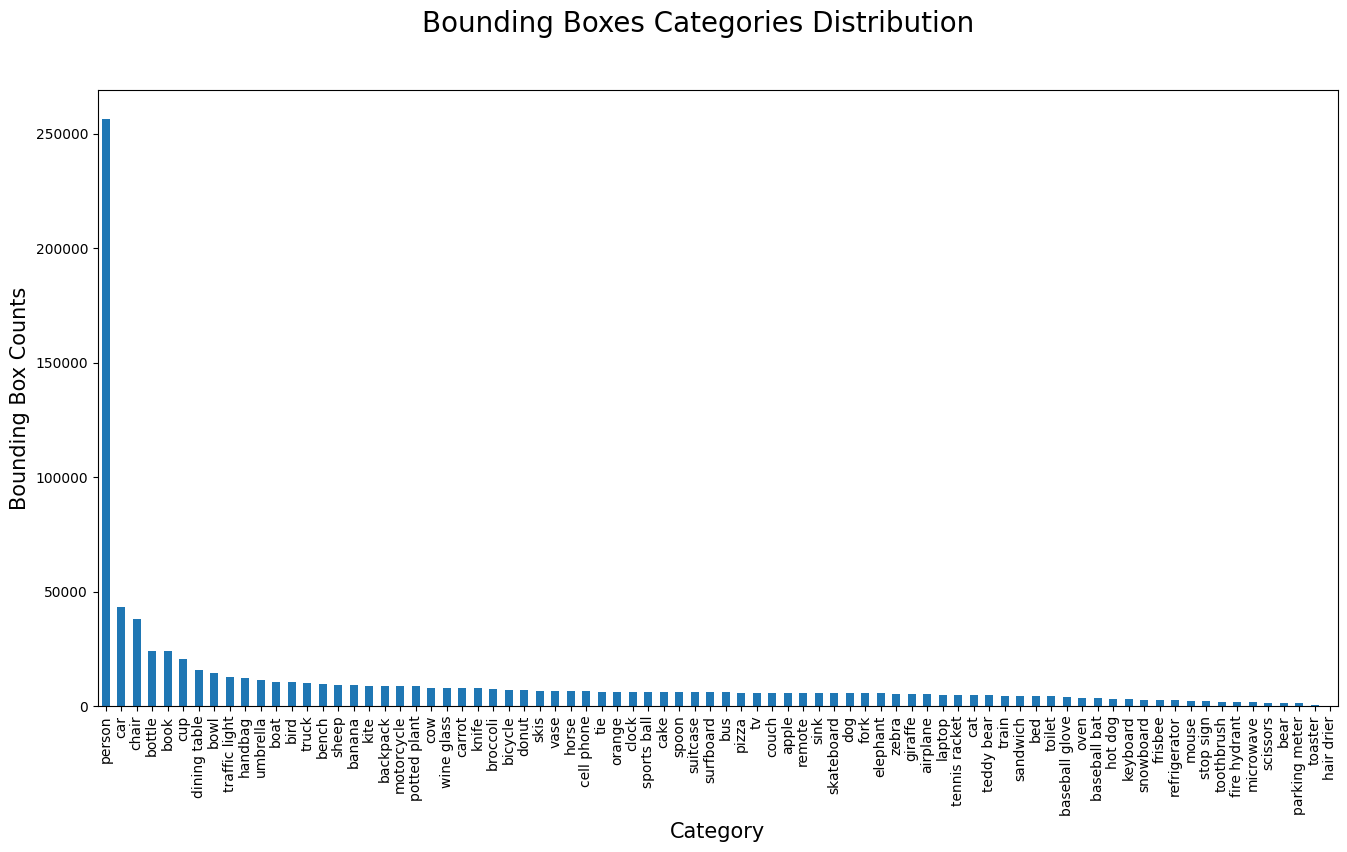

In [15]:
fig, ax = plt.subplots(figsize=(16, 8))
category_names_distribution = category_names.value_counts()
category_names_distribution.plot.bar(ax=ax)
fig.suptitle("Bounding Boxes Categories Distribution", fontsize=20)
ax.set_xlabel("Category", fontsize=15)
ax.set_ylabel("Bounding Box Counts", fontsize=15);

## Pick a Class To Look At

We want to compute the importance only for one class of interest. To do that, we will fit a logistic regression on our training data and calculate the confusion matrix on the testing data. We will take the worst-performing category as our class of interest. 

### Train a Logistic Regression Model

In [16]:
clf = LogisticRegression(class_weight="balanced", max_iter=500)
clf = clf.fit(reduced_dim_data["X_train"], reduced_dim_data["y_train"])

### Pick the Class Based On the Confusion Matrix

We will use the confusion matrix to find the class that generated the most false positives. Let's understand this with an example.

We computed the normalized confusion matrix (values between 0 and 1) for five classes: A, B, C, D, and E. The highest value in the confusion matrix was found between the true class A and the predicted class C (ignoring the ones from the main diagonal). This means that class A was confused with class C the most within our testing data. We will consider class C as our class of interest because there might be issues within the labels due to this high confusion between classes A and C.

In [17]:
y_true = reduced_dim_data["y_test"]
y_pred = clf.predict(reduced_dim_data["X_test"])
cm = confusion_matrix(y_true, y_pred, normalize="true")
# To extract the highest confusion we need to ignore the diagonal matrix.
np.fill_diagonal(cm, 0)
# Now we can quickly grab the maximum value out of the matrix.
true_class_id, predicted_class_id = np.where(cm == cm.max())
true_class_id, predicted_class_id = true_class_id[0], predicted_class_id[0]
print(f"{true_class_id=} ---> {predicted_class_id=}")

true_class_id=47 ---> predicted_class_id=49


In [18]:
# We will use the classes array as a mapping between the confusion matrix index and their real COCO category id.
cm_idx_to_coco_id_mapping = classes

In [19]:
# The class of interest is represented by the class with the most false positives relative to the total normal of samples.
of_interest_continuous_class_id = predicted_class_id
# Map the index of the confusion matrix to its COCO ID.
of_interest_coco_class_id = cm_idx_to_coco_id_mapping[of_interest_continuous_class_id]
# Now we can quickly extract the name of the class.
of_interest_class_name = coco_category_ids_to_names_mapping[of_interest_coco_class_id]

print(f"Our class of interest is '{of_interest_class_name}'.")
print(f"It has a total of {category_names_distribution[of_interest_class_name]} samples/bounding boxes.")

Our class of interest is 'orange'.
It has a total of 6300 samples/bounding boxes.


In [20]:
# Out of curiosity, let's see what is the class that was confused the most.
true_class_coco_id = cm_idx_to_coco_id_mapping[true_class_id]
true_class_coco_name = coco_category_ids_to_names_mapping[true_class_coco_id]

print(f"The most confused class is '{true_class_coco_name}'.")
print(f"It has a total of {category_names_distribution[true_class_coco_name]} samples/bounding boxes.")

The most confused class is 'apple'.
It has a total of 5773 samples/bounding boxes.


## Compute the Importance Using Coresets

With the help of the `CoresetTreeServiceLG` class, we will find the samples of interest within the `of_interest_continuous_class_id` class. This service will compute the coreset relative to the given data and the logistic regression model. Using the coreset, it can assign importance values with the help of which we will find our samples of interest. We will build the Coreset just on the oranges and apples classes, as these are the classes we’re interested in, but it is of course possible to build the Coreset on the entire dataset

In [21]:
# select for X_train and y_train only the 'orange' and 'apple' classes
selected_classes = [k for i, (k, v) in enumerate(coco_category_ids_to_names_mapping.items()) 
                    if v in ['orange', 'apple']]
X_train = data["X_train"]
y_train = data["y_train"]
train_selected_idx = np.in1d(y_train, selected_classes)
y_train = y_train[train_selected_idx]
X_train = X_train[train_selected_idx]
train_selected_indices = np.arange(len(data["y_train"]))[train_selected_idx]

In [22]:
start_service_time = time.time()
service = CoresetTreeServiceLG(optimized_for='cleaning', n_instances=len(y_train))
service.build(X_train, y_train)
important_samples = service.get_cleaning_samples(class_size={of_interest_coco_class_id: "all"})
important_sample_indices = important_samples['idx']
# convert to full dataset indices
important_sample_indices = train_selected_indices[important_sample_indices]
important_sample_values = important_samples['importance']
end_service_time = time.time()

print(f"Coresets computed in {end_service_time - start_service_time:.2f} seconds")

Coresets computed in 24.46 seconds


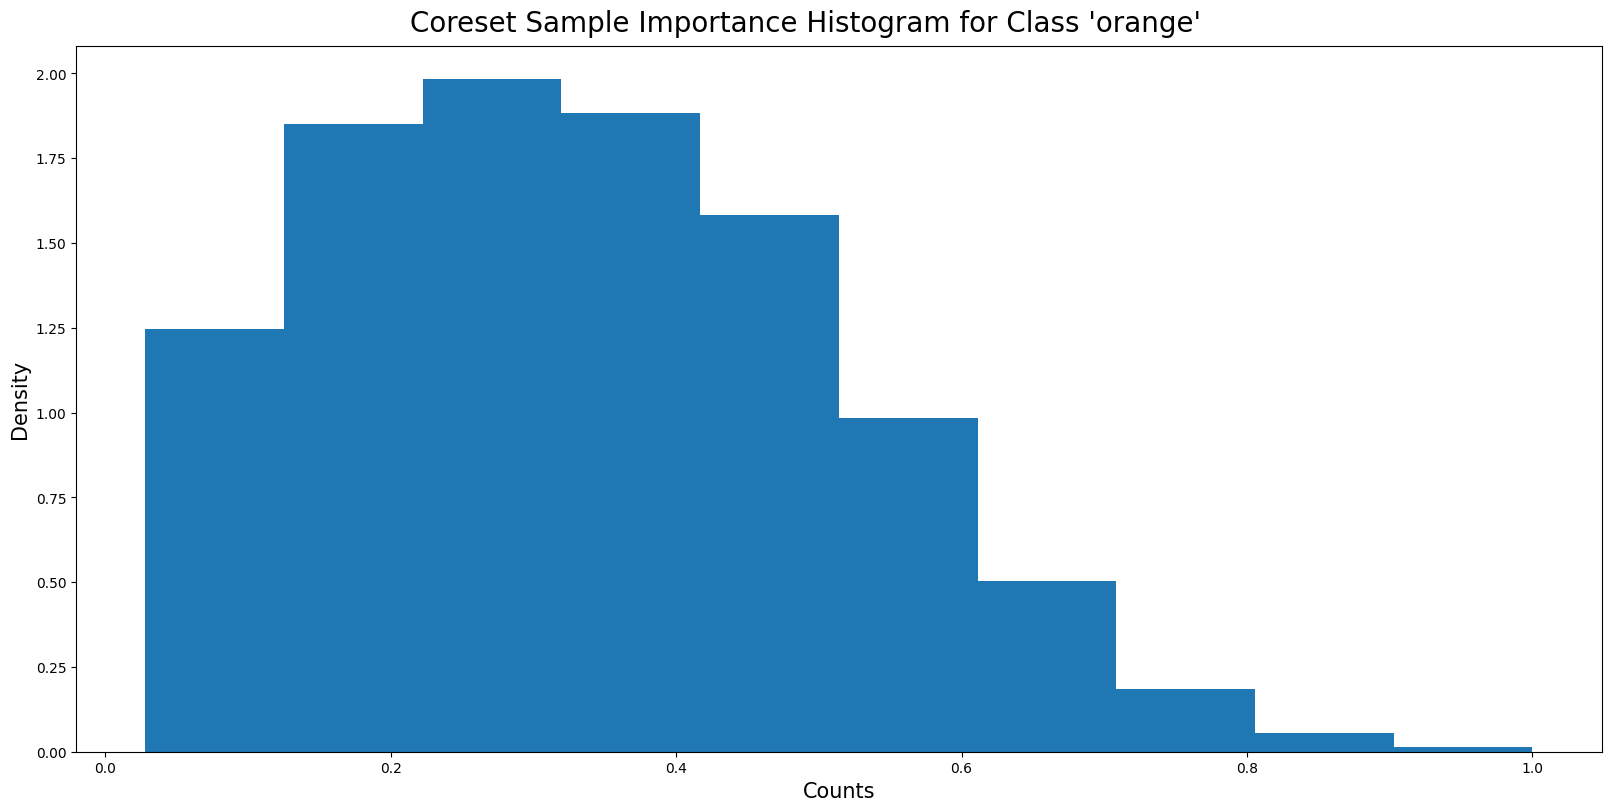

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), constrained_layout=True)
fig.suptitle(f"Coreset Sample Importance Histogram for Class '{of_interest_class_name}'", fontsize=20)
ax.set_xlabel("Counts", fontsize=15)
ax.set_ylabel("Density", fontsize=15)

plt.hist(
    important_sample_values,
    bins=10,
    density=True,
    );

## Visualize Samples Sorted By Importance

We will visualize the data samples from the top and bottom ends of the importance spectrum based on what we computed using the coresets service.

While the get_cleaning_samples function is deterministic, the Coreset build function may run a randomized solver to accelerate Coreset build time if there are more than 512 features. Since our neural network in this Notebook has 2048 features, your own results when running get_cleaning_samples and visualizing the top and bottom samples on this Notebook, may be slightly different, due to the randomized solver.

One important thing to highlight is that the indices and values returned by the coreset service are already sorted in descending order.

### Define Vizualization Functions

In [24]:
def visualize(metadata: pd.DataFrame, importance_values: np.ndarray, title: str):
    """Generator used to visualize the samples and annotations within the metadata DataFrame. 

    Args:
        metadata (pd.DataFrame): metadata containing all the COCO IDs of interest.
        importance_values (np.ndarray): the importance values of the items enumerated in metadata
        title (str): a title that will be rendered on the plot
    """

    num_sections = len(metadata) // 3 + 1
    chunks_metadata = np.array_split(metadata, num_sections)
    chunks_importance_values = np.array_split(importance_values, num_sections)
    for i, (chunk_metadata, chunk_importance_values) in enumerate(zip(chunks_metadata, chunks_importance_values)):
        # Load images.
        images = coco_train.loadImgs(ids=chunk_metadata["Image ID"].tolist())
        images = [
            Image.open(
                get_images_path(DATA_DIR, "train", image["file_name"])
            ) for image in images
        ]

        # Load annotations.
        anns = coco_train.loadAnns(ids=chunk_metadata["Annotation ID"].tolist())

        render(images, anns, chunk_importance_values, title)

        yield    


def get_images_path(root_dir: Path, split: str, image_name: str) -> Path:
    """Utility function used to compute the path to the COCO images."""
    return Path(root_dir) / "images" / f"{split}2017" / image_name


def render(images: List[Image.Image], anns: List[dict], importance_values: List[float], title: str) -> plt.Figure:
    """Utility function that takes images and annotations and renders them on a matplotlib figure."""

    num_rows = len(images)
    fig, ax = plt.subplots(num_rows, 3, figsize=(10, 10))

    for i, (image, ann, importance_value) in enumerate(zip(images, anns, importance_values)):
        # Draw the attention mask.
        black_image = np.zeros_like(image)
        x_min, x_max, y_min, y_max = get_bbox(ann)
        black_image[y_min:y_max, x_min:x_max] = 255
        ax[i, 0].axis('off')
        ax[i, 0].imshow(black_image, aspect='auto')

        # Draw the raw image.
        ax[i, 1].axis('off')
        ax[i, 1].imshow(image, aspect='auto')

        # Draw the image with the given annotation.
        ax[i, 2].axis('off')
        ax[i, 2].imshow(image, aspect='auto')
        x_min, y_min, width, height = ann["bbox"]
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax[i, 2].add_patch(rect)

    category_name = coco_category_ids_to_names_mapping[anns[0]["category_id"]]
    ax[0, 0].title.set_text("Label Mask")
    ax[0, 1].title.set_text("Raw Image")
    ax[0, 2].title.set_text(f"Label = '{category_name}'")

    formatted_importance_values = [f"{importance_value:.2f}" for importance_value in importance_values]
    formatted_importance_values = " | ".join(formatted_importance_values)
    fig.suptitle(f"{title} ~ Importance = {formatted_importance_values}")


def get_bbox(ann: dict) -> tuple:
    """Utility function used to map get the bounding box from an annotation dictionary."""
    
    bbox = ann["bbox"]
    x_min, y_min, width, height = bbox
    x_max, y_max = x_min + width, y_min + height
    x_min, x_max, y_min, y_max = round(x_min), round(x_max), round(y_min), round(y_max)

    return x_min, x_max, y_min, y_max

### Define Additional Helper Functions

In [25]:
def get_top(data: dict, important_sample_indices: np.ndarray, important_sample_values: np.ndarray) -> Tuple[pd.DataFrame, np.ndarray]:
    """Utility function that extracts top-importance samples based on the output from the coresets service."""

    top_important_sample_indices = important_sample_indices[:EXPORT_TOP_N_SAMPLES]
    top_important_metadata_train = data["metadata_train"].loc[top_important_sample_indices]
    top_importance_values_train = important_sample_values[:EXPORT_TOP_N_SAMPLES]

    return top_important_metadata_train, top_importance_values_train


def get_bottom(data, important_sample_indices: np.ndarray, important_sample_values: np.ndarray) -> Tuple[pd.DataFrame, np.ndarray]:
    """Utility function that extracts bottom-importance samples based on the output from the coresets service."""
    
    bottom_important_samples = important_sample_indices[-EXPORT_BOTTOM_N_SAMPLES:]
    bottom_important_metadata_train = data["metadata_train"].loc[bottom_important_samples]
    bottom_importance_values = important_sample_values[-EXPORT_BOTTOM_N_SAMPLES:]
    
    return bottom_important_metadata_train, bottom_importance_values

### Visualize Top Importance

We will find hard-to-predict samples (weird shapes, occluded, multiple objects instead of one, etc.) or mislabeled samples within the top-importance samples. Remember that theoretically, we exported only samples with `iscrowd = False`. Thus we should expect only bounding boxes that contain a single orange.

In [26]:
top_important_metadata_train, top_importance_values_train = get_top(data, important_sample_indices, important_sample_values)
top_importance_visualizer = visualize(
    metadata=top_important_metadata_train,
    importance_values=top_importance_values_train,
    title="Top Importance"
)

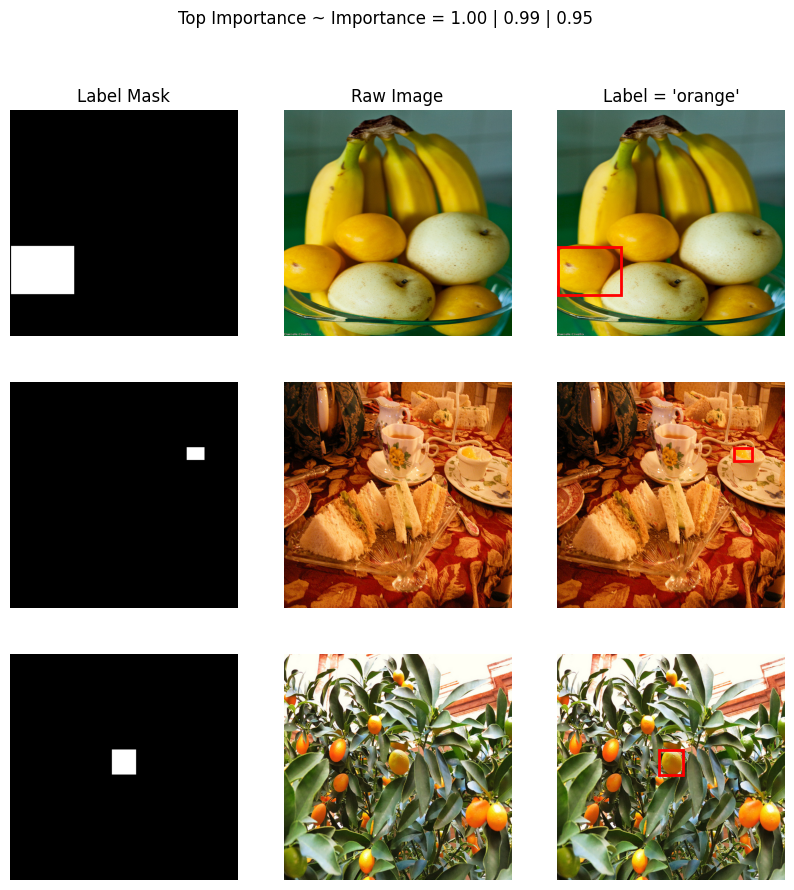

In [27]:
next(top_importance_visualizer);

The first row consists of a bounding box that contains a bag of green oranges and a motorcycle. As said, `iscrowd = False`. Thus, we shouldn't expect bounding boxes with multiple oranges. 

The second row consists of a group/crowd of lemons, not even oranges.

The third row consists of an orange occluded by pears, similar to apples (the most confused class).

We can confidently say that the first two annotations are wrong, while the third is a hard-use case of detecting an orange.



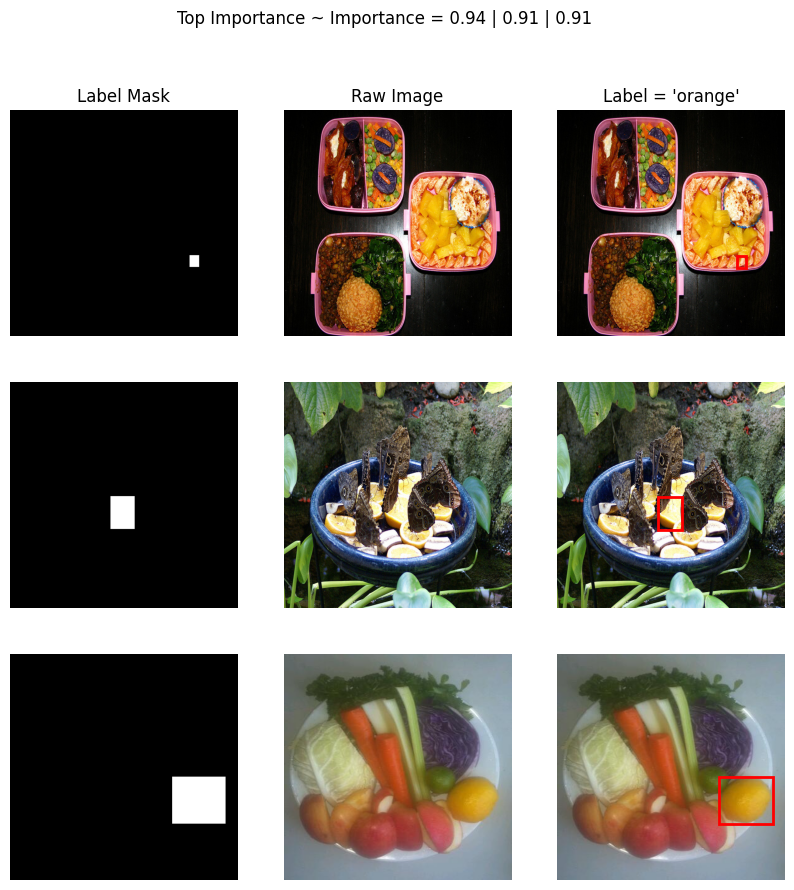

In [28]:
next(top_importance_visualizer);

The first row has a bounding box that spans multiple types of fruits (and even a person), not even multiple oranges. The second row consists of a slice of lime. The third row shows again a very occluded orange. Again, the first two annotations are incorrect, while the third represents a difficult scenario.

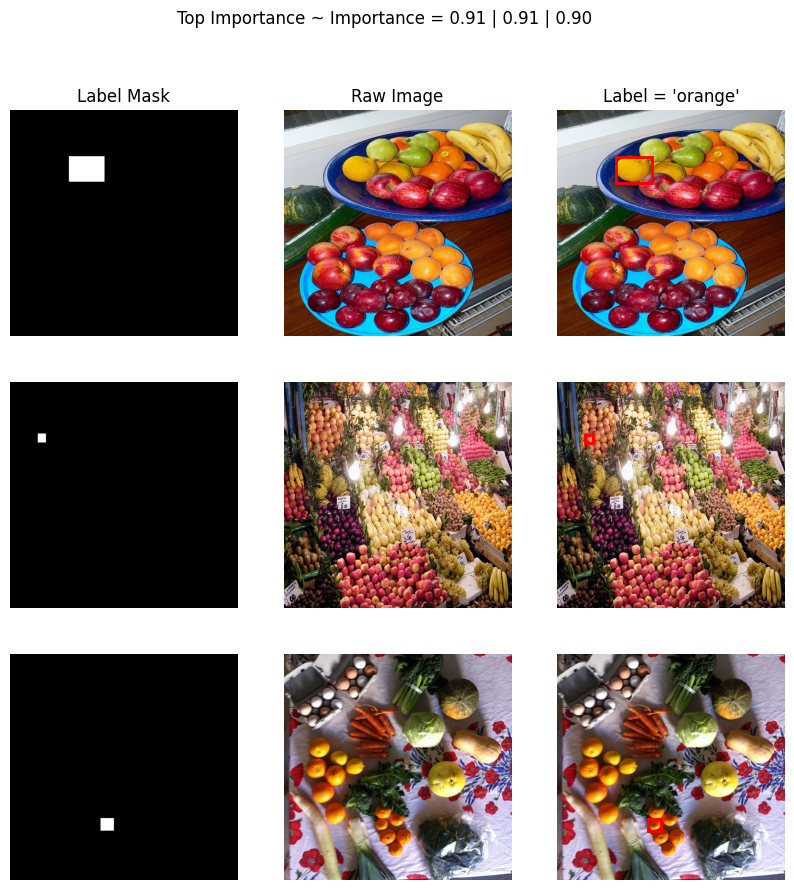

In [29]:
next(top_importance_visualizer);

This time the first row consists of a slice of orange occluded by a butterfly, the second one is a crowd of oranges, and the third is a crowd of apples. Only the first sample is correct in this scenario, but it still represents a complicated example. 

The main idea is that in the **top percentile** of the **high importance** samples, we can find mislabeled or interesting samples that help us debug the labels and understand the dataset better.

### Visualize Bottom Importance

Within the bottom importance samples, we will see only correctly labeled samples, that include only a single orange. 

In [30]:
bottom_important_metadata_train, bottom_importance_values_train = get_bottom(data, important_sample_indices, important_sample_values)
bottom_importance_visualizer = visualize(
    metadata=bottom_important_metadata_train,
    importance_values=bottom_importance_values_train,
    title="Bottom Importance"
)

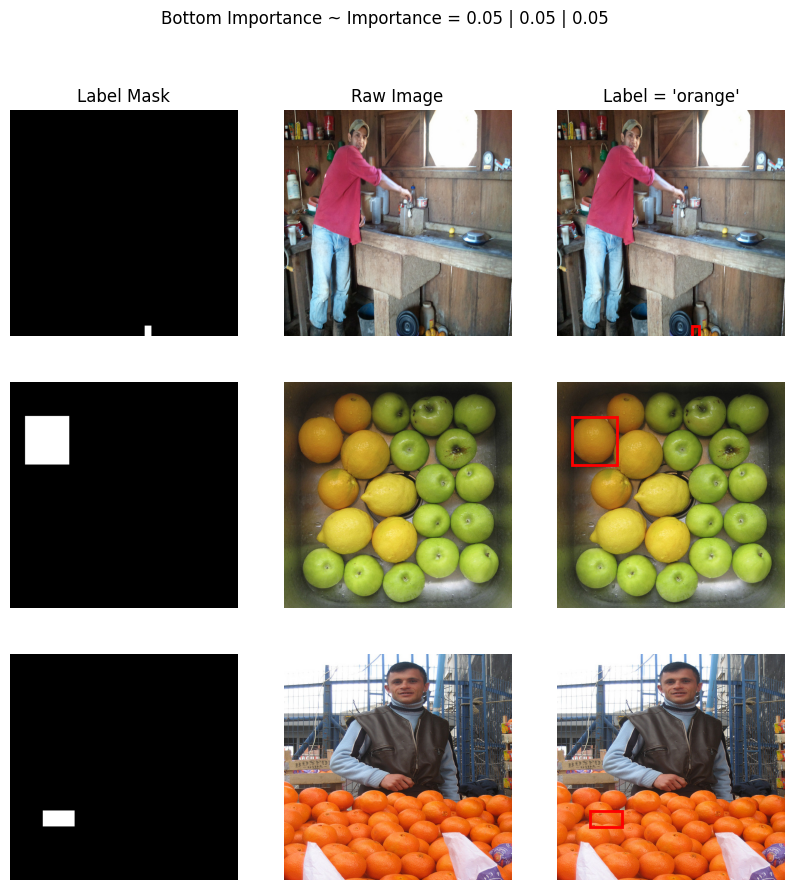

In [31]:
next(bottom_importance_visualizer);

As we can see, all nine scenarios are correct, as they include a single orange correctly labeled (although quite small and far away).

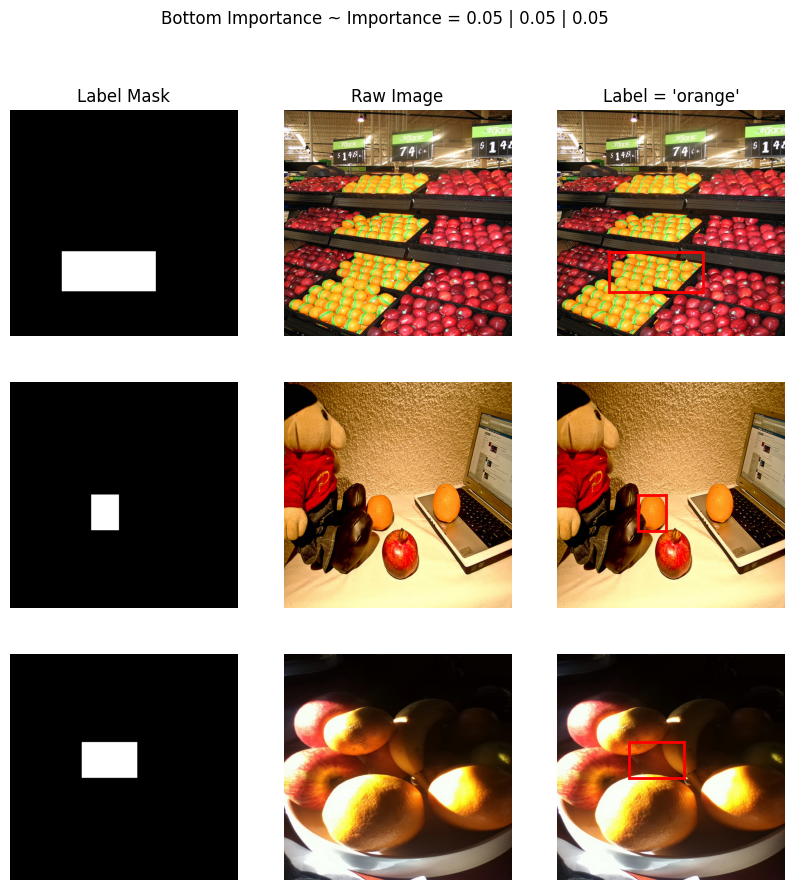

In [32]:
next(bottom_importance_visualizer);

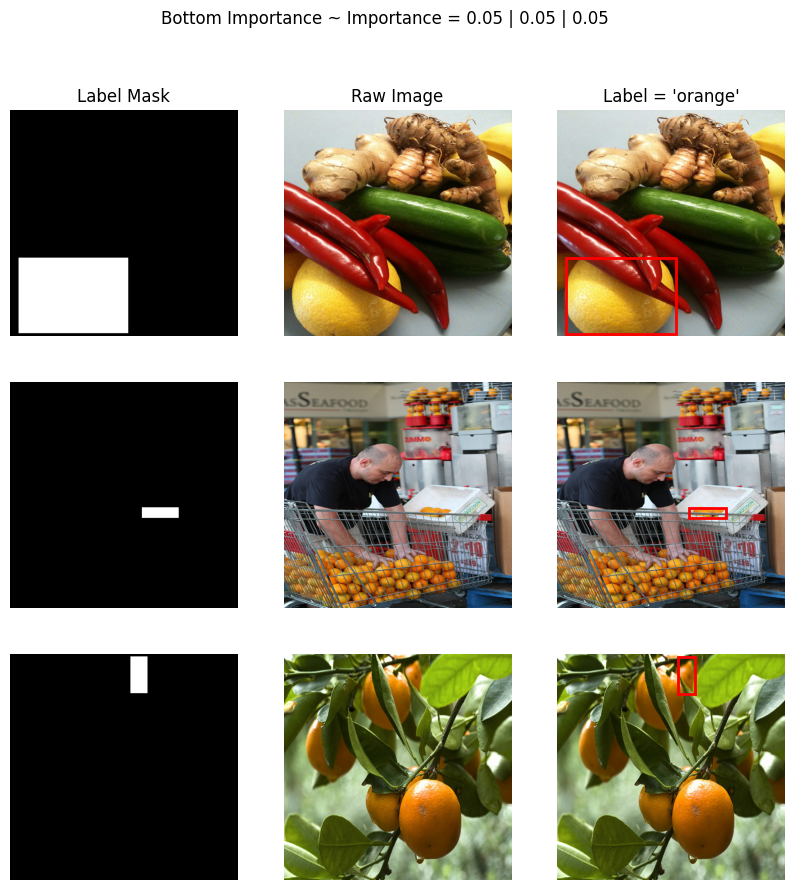

In [33]:
next(bottom_importance_visualizer);

## Conclusion

In conclusion, using the DataHeroes Coresets library, we used an innovative way to find instances with potentially faulty labels. Thus, speeding up the process of debugging and understanding your dataset.

We found our class of interest by computing the confusion matrix. We used the Coresets logistic regression engine to calculate the important values of our class of interest. Afterward, we rendered the top and bottom percentiles using the sorted samples relative to the importance computed by the coresets. We have found challenging targets (weird shapes, occluded, multiple objects instead of one) or wrongly annotated bounding boxes within the top percentile of our samples. While in the bottom percentile, we have seen correctly labeled samples.